In [38]:
import os
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from pathlib import Path

In [28]:
SR = 22050
N_MFCC = 13
genre_list = [ 'jazz', 'rock', 'pop', 'hiphop']
CHUNK_DURATION = 3

In [29]:
def split_audio_to_chunks(file_path, chunk_duration, sr=SR):
    try:
        y, _ = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_path}: {e}")
        return []
    chunk_size = int(chunk_duration * sr)
    chunks = [y[i:i + chunk_size] for i in range(0, len(y), chunk_size)]
    
    if len(chunks[-1]) < chunk_size:
        padded_chunk = np.pad(chunks[-1], (0, chunk_size - len(chunks[-1])), 'constant')
        chunks[-1] = padded_chunk
    
    return chunks


In [34]:
def extract_features_from_chunks(chunks, sr=SR, n_mfcc=N_MFCC):
    all_features = []
    max_len = 0  

    for chunk in chunks:
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=chunk, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=chunk, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=chunk, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=chunk, sr=sr)
        rms = librosa.feature.rms(y=chunk)
        zcr = librosa.feature.zero_crossing_rate(y=chunk)

        max_len = max(max_len, mfcc.shape[1])

        features = {
            'mfcc': mfcc,
            'chroma': chroma,
            'spectral_centroid': spectral_centroid,
            'spectral_rolloff': spectral_rolloff,
            'spectral_bandwidth': spectral_bandwidth,
            'rms': rms,
            'zcr': zcr,
        }
        all_features.append(features)

    processed_features = []
    for features in all_features:
        min_rows = min(f.shape[0] for f in features.values())
        
        padded_features = [
            np.pad(f[:min_rows, :], ((0, 0), (0, max_len - f.shape[1])), mode='constant') for f in features.values()
        ]

        combined_features = np.hstack(padded_features)
        processed_features.append(combined_features.T) 

    return np.array(processed_features)

In [35]:
audio_dir = Path("/Users/ajzansejlhanova/Desktop/aai")
if not os.path.exists(audio_dir):
    raise FileNotFoundError(f"Указанный путь к аудиофайлам не существует: {audio_dir}")


audio_files = [os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if file.endswith('.mp3')]
if not audio_files:
    raise FileNotFoundError("Не найдено файлов с расширением .mp3 в указанной директории.")

wav_files = []
for mp3_file in audio_files:
    wav_file = mp3_file.replace('.mp3', '.wav')
    convert_mp3_to_wav(mp3_file, wav_file)
    wav_files.append(wav_file)
    try:
        os.remove(mp3_file)  
    except Exception as e:
        print(f"Не удалось удалить файл {mp3_file}: {e}")

if len(wav_files) % len(genre_list) != 0:
    raise ValueError("Количество файлов не кратно количеству жанров. Проверьте данные.")

genres = ['jazz', 'rock', 'pop', 'hiphop'] * (len(wav_files) // len(genre_list))

X, y = [], []
for file_path, genre in zip(wav_files, genres):
    chunks = split_audio_to_chunks(file_path, CHUNK_DURATION)
    features = extract_features_from_chunks(chunks)
    if len(features) > 0:  
        X.append(features)
        y.extend([genre_list.index(genre)] * len(features))

if not X:
    raise ValueError("Не удалось извлечь признаки из аудиофайлов. Проверьте данные.")

X = np.vstack(X)
y = to_categorical(y, num_classes=len(genre_list))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2401 - loss: 5223.0859 - val_accuracy: 0.4912 - val_loss: 2.2627
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6389 - loss: 1.2798 - val_accuracy: 0.5439 - val_loss: 1.0522
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5507 - loss: 1.1903 - val_accuracy: 0.5789 - val_loss: 0.9502
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6333 - loss: 0.7994 - val_accuracy: 0.5789 - val_loss: 0.8545
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7746 - loss: 0.4697 - val_accuracy: 0.6491 - val_loss: 1.0504
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8646 - loss: 0.3458 - val_accuracy: 0.6316 - val_loss: 1.0122
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9300 - loss: 0.2300 - val_accuracy: 0.7368 - val_loss: 0.8448
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9240 - loss: 0.1796 - val_accuracy: 0.7368 

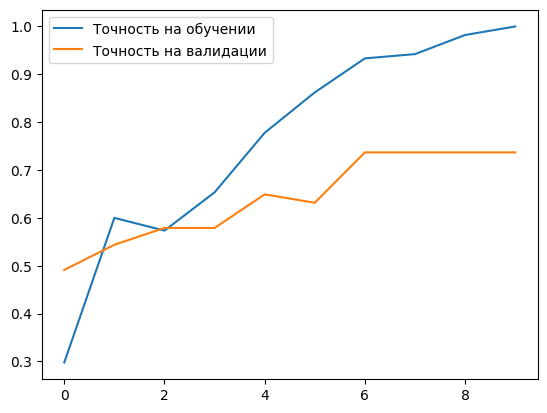

In [39]:
steps = X.shape[1] 
features = X.shape[2]  
num_classes = len(genre_list)  

model = Sequential([
    Input(shape=(steps, features)), 
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.legend()
plt.show()

accuracy: переобучения болып кетіп тұр ғой деймін. Музыка аз болған соң деп ойлап тұрм, тағыда қарап көремін

In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6996 - loss: 1.0800
Test Loss: 0.9327, Test Accuracy: 0.7368
